## Tâche de classification {VRAI} vs {FAUX}

Etudiants : Cazeres Mathieu (22200082), Martin-Chantereau Etienne (21909526), Moreaux Victor (22200010), Poiret Valentin (21609227)

_____________________________________________________________________________________________________
_____________________________________________________________________________________________________
                    
## Introduction Notebook
        
_____________________________________________________________________________________________________
_____________________________________________________________________________________________________

        -> Importation librairies

In [3]:
import pandas as pd
# fonctions utilities (affichage, confusion, etc.)
from Fonction.MyNLPUtilities import *
# fonctions utilities (fonction de clean, import etc etc)
from Fonction.myFonction import *
from Fonction.AllModels import *

        -> Chargement des données brutes

In [4]:
Init_train = pd.read_csv('./Data_brut/HAI817_Projet_train.csv', sep=",")
Init_test = pd.read_csv('./Data_brut/HAI817_Projet_test.csv', sep=",")
data_brute = pd.concat([Init_train,Init_test], ignore_index = True)

print("data_brute avant drop de duplicate : \n", data_brute['our rating'].value_counts(),'\n')
data_brute = data_brute.drop_duplicates()
print("data après drop de duplicate : \n", data_brute['our rating'].value_counts(),'\n')


data_to_test = data_brute[~data_brute['our rating'].isin(['mixture'])]
data_to_test = data_to_test.drop(columns=['public_id', 'ID'])
print("data_to_test avant drop duplicates : \n", data_to_test['our rating'].value_counts(),'\n')
data_to_test = data_to_test.drop_duplicates()
print("datato_test après drop duplicates : \n", data_to_test['our rating'].value_counts(),'\n')

display(data_to_test.describe())

data_brute avant drop de duplicate : 
 false      893
true       421
mixture    414
other      148
Name: our rating, dtype: int64 

data après drop de duplicate : 
 false      815
true       411
mixture    374
other      127
Name: our rating, dtype: int64 

data_to_test avant drop duplicates : 
 false    815
true     411
other    127
Name: our rating, dtype: int64 

datato_test après drop duplicates : 
 false    801
true     407
other    126
Name: our rating, dtype: int64 



,text,title,our rating
count,1334,1324,1334
unique,1323,1220,3
top,ADVERTISEMENT The fire that gutted a flank of ...,Marine Corps. Rebukes Pelosi: “WE DON’T WORK F...,false
freq,2,4,801


        -> Initialisation des dataframes équilibrage 

Lors de la visualisation les différentes données, nous nous sommes rendus compte que les données n'était pas du tout bien isolés je décide donc de tester tout les modèles en prenant différente classification : Texte, Titre, Texte+Titre pour ensuite sélectionner le meilleur de classification que je souhaite et le meilleur classifieur.

Je crée donc 3 dataframe correspondant à chaque type de classification.  
J'équilibre les dataframes en fonctions du nombre de other en appliquant la formule suivante : 
    nombre_de_True  = len(Other)/2
    nombre_de_False = len(Other)/2
    nombre_de_Other = Nombre de other dans le jeu de données d'origine 
Au regard du faible nombre d'other dans le jeu de données nous décidons d'opérer un oversampling d'environ 20% sur les données classées others

In [6]:
from pandas import DataFrame


def initDataToTest(df : DataFrame, columnToDrop : list[str], columnToCount : str, valueToMerge : list[str], size : int, valueOfReplacement : str) :
    data = df.copy()
    data = data.drop(columns=columnToDrop)
    print("data", valueToMerge ,"avant drop duplicates : \n", data[columnToCount].value_counts(),'\n')
    data = data.drop_duplicates()
    print("data", valueToMerge ,"après drop duplicates : \n", data[columnToCount].value_counts(),'\n')
    if size > 0 :
        data = balanceSample(data,size,valueToMerge)
    if valueOfReplacement is not None : 
        data = data.replace(valueToMerge, valueOfReplacement)
    return data

❗IMPORTANT❗
Ceci est le code permettant de créer des jeux de données équilibrés, si vous souhaitez les recréers il faut recharger la cellule attention toutefois cela risque d'écraser les anciens dataframes si vous les enregistrer par la suite et faussera les résultats des classifieurs

In [5]:
"""
print("dataFrame text only :")
df_text = pd.concat([initDataToTest(data_to_test[data_to_test['our rating'] == 'other'],['title'], ['our rating'], ['other'], 0, None),
                             initDataToTest(data_to_test,['title'], ['our rating'], ['true', 'false'], 75,'true/false')])
df_text = balanceSample(df_text, 150, ['true/false', 'other'])
X_train_text  = df_text['text']
Y_train_text = df_text['our rating']


print("dataFrame title only :")
df_title = pd.concat([initDataToTest(data_to_test[data_to_test['our rating'] == 'other'],['text'], ['our rating'], ['other'], 0, None),
                             initDataToTest(data_to_test,['text'], ['our rating'], ['true', 'false'], 75,'true/false')])
df_title = balanceSample(df_title, 150, ['true/false', 'other'])
X_train_title = df_title['title']
Y_train_title = df_title['our rating']


print("dataFrame text_title concatenate only :")
df_text_titre_concat = data_to_test.copy()
df_text_titre_concat = df_text_titre_concat.fillna('')
df_text_titre_concat['title_text'] = df_text_titre_concat['title'].str.cat(df_text_titre_concat['text'], sep=' ')
df_text_and_title = pd.concat([initDataToTest(df_text_titre_concat[df_text_titre_concat['our rating'] == 'other'],['text', 'title'], ['our rating'], ['other'], 0, None),
                             initDataToTest(df_text_titre_concat,['text', 'title'], ['our rating'], ['true', 'false'], 75,'true/false')])
df_text_and_title = balanceSample(df_text_and_title, 150, ['true/false', 'other'])
X_train_text_and_title = df_text_and_title['title_text']
Y_train_text_and_title = df_text_and_title['our rating']
"""


dataFrame text only :
data ['other'] avant drop duplicates : 
 our rating
other         126
dtype: int64 

data ['other'] après drop duplicates : 
 our rating
other         126
dtype: int64 

data ['true', 'false'] avant drop duplicates : 
 our rating
false         801
true          407
other         126
dtype: int64 

data ['true', 'false'] après drop duplicates : 
 our rating
false         800
true          400
other         126
dtype: int64 

dataFrame title only :
data ['other'] avant drop duplicates : 
 our rating
other         126
dtype: int64 

data ['other'] après drop duplicates : 
 our rating
other         125
dtype: int64 

data ['true', 'false'] avant drop duplicates : 
 our rating
false         801
true          407
other         126
dtype: int64 

data ['true', 'false'] après drop duplicates : 
 our rating
false         702
true          400
other         125
dtype: int64 

dataFrame text_title concatenate only :
data ['other'] avant drop duplicates : 
 our rating
other  

    -> Enregistrement DataFrame à lancer seulement si de nouveau jeux de données sont crées

In [8]:
df_text.to_csv("./Data_equilibre/True_And_False_VS_Other/balanced_df_TFO_text.csv")
df_title.to_csv("./Data_equilibre/True_And_False_VS_Other/balanced_df_TFO_title.csv")
df_text_and_title.to_csv("./Data_equilibre/True_And_False_VS_Other/balanced_df_TFO_text_and_title.csv")

        -> Chargement des jeux de données équilibrés

In [10]:
df_text = pd.read_csv("./Data_equilibre/True_And_False_VS_Other/balanced_df_TFO_text.csv")
X_train_text  = df_text['text']
Y_train_text = df_text['our rating']
df_title = pd.read_csv("./Data_equilibre/True_And_False_VS_Other/balanced_df_TFO_title.csv")
X_train_title = df_title['title']
Y_train_title = df_title['our rating']
df_text_and_title = pd.read_csv("./Data_equilibre/True_And_False_VS_Other/balanced_df_TFO_text_and_title.csv")
X_train_text_and_title = df_text_and_title['title_text']
Y_train_text_and_title = df_text_and_title['our rating']

        -> Première prédiction des modèles 

Cela permet de partir sur une première estimation pour savoir lesquels sont les plus performants puis nous allons vérifier cela après les différents test

Fonction Text


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\33683\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Evaluation de  MultinomialNB
MultinomialNB : 0.660 (0.095) in 0.534 s
Evaluation de  LR
LR : 0.677 (0.083) in 2.817 s
Evaluation de  KNN
KNN : 0.557 (0.109) in 1.219 s
Evaluation de  CART
CART : 0.550 (0.079) in 8.088 s
Evaluation de  RF
RF : 0.643 (0.086) in 12.640 s
Evaluation de  SVM
SVM : 0.690 (0.045) in 308.819 s

Le meilleur resultat : 
Classifier :  SVM  accuracy : 0.690  (0.045)  en 308.819   s

Tous les résultats : 

Classifier :  SVM  accuracy : 0.690  (0.045)  en 308.819   s
Classifier :  LR  accuracy : 0.677  (0.083)  en 2.817   s
Classifier :  MultinomialNB  accuracy : 0.660  (0.095)  en 0.534   s
Classifier :  RF  accuracy : 0.643  (0.086)  en 12.640   s
Classifier :  KNN  accuracy : 0.557  (0.109)  en 1.219   s
Classifier :  CART  accuracy : 0.550  (0.079)  en 8.088   s


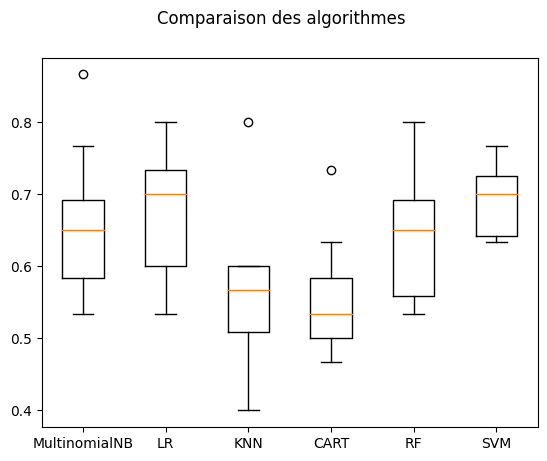

In [11]:
print("Fonction Text")
testAllModel(X_train_text,Y_train_text,5)




Fonction Titre
Evaluation de  MultinomialNB


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\33683\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


MultinomialNB : 0.587 (0.107) in 0.147 s
Evaluation de  LR
LR : 0.617 (0.101) in 0.443 s
Evaluation de  KNN
KNN : 0.560 (0.071) in 0.367 s
Evaluation de  CART
CART : 0.627 (0.071) in 1.949 s
Evaluation de  RF
RF : 0.623 (0.062) in 7.689 s
Evaluation de  SVM
SVM : 0.667 (0.045) in 1.894 s

Le meilleur resultat : 
Classifier :  SVM  accuracy : 0.667  (0.045)  en 1.894   s

Tous les résultats : 

Classifier :  SVM  accuracy : 0.667  (0.045)  en 1.894   s
Classifier :  CART  accuracy : 0.627  (0.071)  en 1.949   s
Classifier :  RF  accuracy : 0.623  (0.062)  en 7.689   s
Classifier :  LR  accuracy : 0.617  (0.101)  en 0.443   s
Classifier :  MultinomialNB  accuracy : 0.587  (0.107)  en 0.147   s
Classifier :  KNN  accuracy : 0.560  (0.071)  en 0.367   s


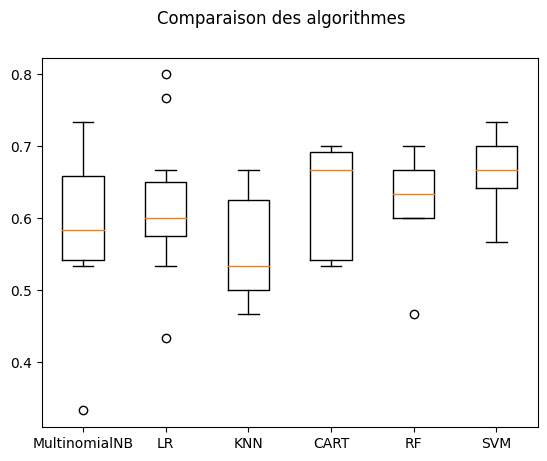

In [12]:
print("Fonction Titre")
testAllModel(X_train_title,Y_train_title,5)

Fonction titre et text 


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\33683\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Evaluation de  MultinomialNB
MultinomialNB : 0.627 (0.090) in 0.522 s
Evaluation de  LR
LR : 0.623 (0.099) in 2.528 s
Evaluation de  KNN
KNN : 0.610 (0.084) in 0.923 s
Evaluation de  CART
CART : 0.577 (0.076) in 8.669 s
Evaluation de  RF
RF : 0.660 (0.059) in 12.323 s
Evaluation de  SVM
SVM : 0.640 (0.080) in 305.789 s

Le meilleur resultat : 
Classifier :  RF  accuracy : 0.660  (0.059)  en 12.323   s

Tous les résultats : 

Classifier :  RF  accuracy : 0.660  (0.059)  en 12.323   s
Classifier :  SVM  accuracy : 0.640  (0.080)  en 305.789   s
Classifier :  MultinomialNB  accuracy : 0.627  (0.090)  en 0.522   s
Classifier :  LR  accuracy : 0.623  (0.099)  en 2.528   s
Classifier :  KNN  accuracy : 0.610  (0.084)  en 0.923   s
Classifier :  CART  accuracy : 0.577  (0.076)  en 8.669   s


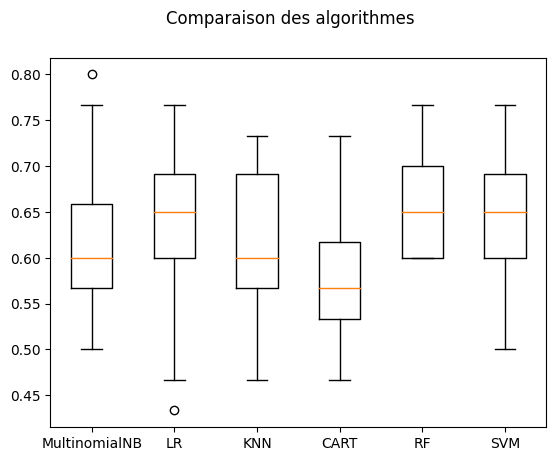

In [13]:
print("Fonction titre et text ")
testAllModel(X_train_text_and_title, Y_train_text_and_title,5)

_____________________________________________________________________________________________________
_____________________________________________________________________________________________________
                    
## 1. Test des Classifieurs avec les données Brutes
_____________________________________________________________________________________________________
_____________________________________________________________________________________________________

        1.1 Test SVC

        ---> Texte

In [12]:
print("Test SVC Text")
testSVC(X_train_text,Y_train_text, 5,'/True_And_False_VS_Other/Texte/data_svc_TFO_Texte')

Test SVC Text
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'svm']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'svm__C': [0.001, 0.01, 0.1, 1, 10], 'svm__gamma': [0.001, 0.01, 0.1, 1], 'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
Fitting 5 folds for each of 2560 candidates, totalling 12800 fits
réalisé en  6501.005 s
Meilleur résultat : 0.703
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: True
	cleaner__getstemmer: False
	cleaner__removedigit: True
	svm__C: 10
	svm__gamma: 1
	svm__kernel: 'rbf'
	tfidf__lowercase: False
	tfidf__stop_words: None

Les premiers résultats : 
      cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
951                       True                False                  True   
620                       True                 True          

Sauvegarde du modèle dans  ./Modele/TFO_svm_not_DE.pkl
Chargement du modèle 

Pipeline(steps=[('cleaner',
                 TextNormalizer(getlemmatisation=True, removedigit=True)),
                ('tfidf', TfidfVectorizer(lowercase=False)),
                ('svm', SVC(C=10, gamma=1, probability=True))])
Accuracy : 0.567
Classification Report
              precision    recall  f1-score   support

       other    0.57143   0.53333   0.55172        15
  true/false    0.56250   0.60000   0.58065        15

    accuracy                        0.56667        30
   macro avg    0.56696   0.56667   0.56618        30
weighted avg    0.56696   0.56667   0.56618        30



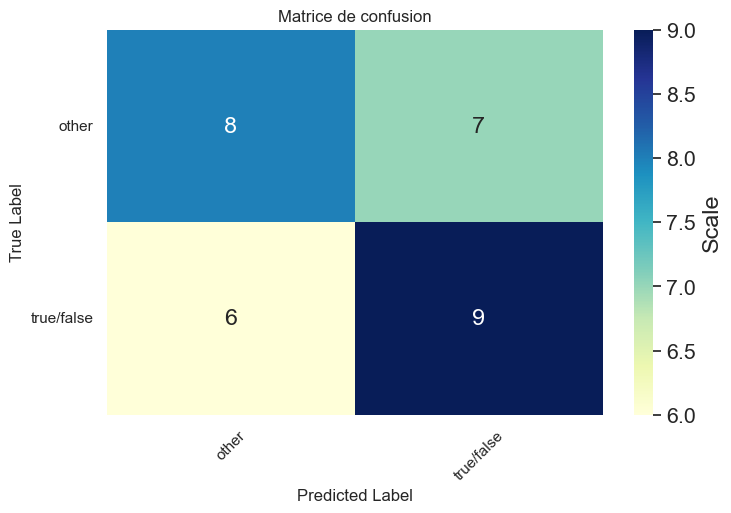

In [20]:
from sklearn.model_selection import train_test_split
import pickle
# Création d'un jeu d'apprentissage et de test
trainsize=0.9 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour
testsize= 0.1
seed=30

train_title,test_title,train_note,test_note=train_test_split(X_train_text,Y_train_text, train_size=trainsize,random_state=seed,test_size=testsize,stratify=Y_train_text)

pipeline=Pipeline([
    ("cleaner", TextNormalizer(removedigit=True, getlemmatisation=True, getstemmer=False)),
    ("tfidf", TfidfVectorizer(lowercase=False, stop_words=None)),
    ('svm', SVC(C=10, gamma=1, kernel='rbf',probability=True))
])
pipeline.fit(train_title,train_note)
filename='./Modele/True_And_False_VS_Other/TFO_svm_not_DE.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(pipeline, open(filename, "wb"))


print ("Chargement du modèle \n")
# le chargement se fait via la fonction load
clf_loaded = pickle.load(open(filename, 'rb'))
# affichage du modèle sauvegardé
print (clf_loaded)


# test  avec les données qu'il a apprise c'est parfait woahhha c'est beau
y_pred = clf_loaded.predict(test_title)
# autres mesures et matrice de confusion
MyshowAllScores(test_note,y_pred)

        ---> Titre

In [13]:
print("Test SVC Titre")
testSVC(X_train_title,Y_train_title, 5, '/True_And_False_VS_Other/Titre/data_svc_TFO_Titre')

Test SVC Titre
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'svm']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'svm__C': [0.001, 0.01, 0.1, 1, 10], 'svm__gamma': [0.001, 0.01, 0.1, 1], 'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
Fitting 5 folds for each of 2560 candidates, totalling 12800 fits
réalisé en  222.986 s
Meilleur résultat : 0.660
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: True
	cleaner__getstemmer: False
	cleaner__removedigit: False
	svm__C: 0.001
	svm__gamma: 0.001
	svm__kernel: 'poly'
	tfidf__lowercase: True
	tfidf__stop_words: 'english'

Les premiers résultats : 
       cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
2296                      False                False                 False   
2360                      False               

        ---> Texte et Titre

In [4]:
print("Test SVC Text and Titre")
testSVC(X_train_text_and_title,Y_train_text_and_title, 5,'/True_And_False_VS_Other/Titre_And_Texte/data_svc_TFO_Titre_And_Texte')

Test SVC Text and Titre
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'svm']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'svm__C': [0.001, 0.01, 0.1, 1, 10], 'svm__gamma': [0.001, 0.01, 0.1, 1], 'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
Fitting 5 folds for each of 2560 candidates, totalling 12800 fits
réalisé en  6559.843 s
Meilleur résultat : 0.673
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: True
	cleaner__getstemmer: False
	cleaner__removedigit: False
	svm__C: 1
	svm__gamma: 0.001
	svm__kernel: 'linear'
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
       cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
1201                       True                False                 False   
1153                       True            

        1.2 Test RFC

        ---> Texte

In [5]:
print("Test RFC Text")
testRFC(X_train_text,Y_train_text,5,'/True_And_False_VS_Other/Texte/data_RFC_TFO_Texte')

Test RFC Text
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'rfc']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'rfc__n_estimators': [500, 1200], 'rfc__max_depth': [25, 30], 'rfc__min_samples_split': [5, 10, 15], 'rfc__min_samples_leaf': [1, 2]}
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
réalisé en  3044.708 s
Meilleur résultat : 0.720
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: True
	cleaner__getstemmer: True
	cleaner__removedigit: False
	rfc__max_depth: 30
	rfc__min_samples_leaf: 2
	rfc__min_samples_split: 10
	rfc__n_estimators: 1200
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
      cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
181                       True                 True                 False   
141  

Sauvegarde du modèle dans  ./Modele/True_And_False_VS_Other/TFO_RFC_not_DE.pkl.pkl
Chargement du modèle 

Pipeline(steps=[('cleaner',
                 TextNormalizer(getlemmatisation=True, getstemmer=True)),
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('rfc',
                 RandomForestClassifier(max_depth=30, min_samples_leaf=2,
                                        min_samples_split=10,
                                        n_estimators=1200))])
Accuracy : 0.633
Classification Report
              precision    recall  f1-score   support

       other    0.61111   0.73333   0.66667        15
  true/false    0.66667   0.53333   0.59259        15

    accuracy                        0.63333        30
   macro avg    0.63889   0.63333   0.62963        30
weighted avg    0.63889   0.63333   0.62963        30



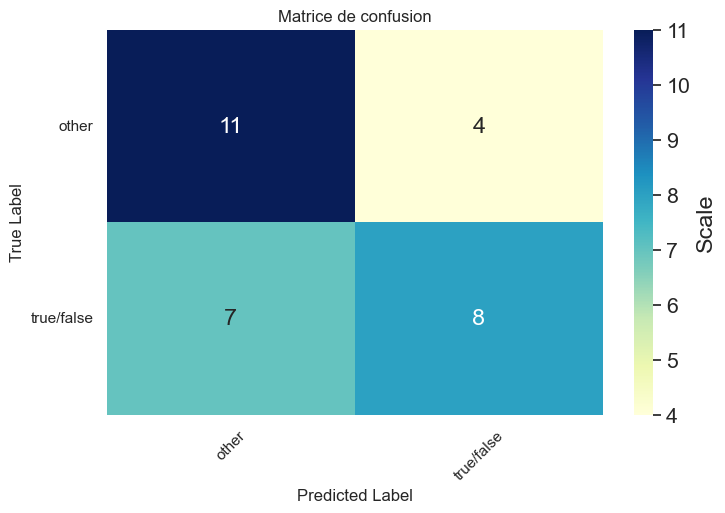

In [21]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# Création d'un jeu d'apprentissage et de test
trainsize=0.9 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour
testsize= 0.1
seed=30
train_title,test_title,train_note,test_note=train_test_split(X_train_text,Y_train_text, train_size=trainsize,random_state=seed,test_size=testsize,stratify=Y_train_text)

pipeline=Pipeline([
    ("cleaner", TextNormalizer(removedigit=False, getlemmatisation=True, getstemmer=True)),
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words='english')),
    ('rfc', RandomForestClassifier(max_depth=30,min_samples_leaf=2, min_samples_split=10, n_estimators=1200))
])
pipeline.fit(train_title,train_note)
filename='./Modele/True_And_False_VS_Other/TFO_RFC_not_DE.pkl.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(pipeline, open(filename, "wb"))



print ("Chargement du modèle \n")
# le chargement se fait via la fonction load
clf_loaded = pickle.load(open(filename, 'rb'))
# affichage du modèle sauvegardé
print (clf_loaded)


# test  avec les données qu'il a apprise c'est parfait woahhha c'est beau
y_pred = clf_loaded.predict(test_title)
# autres mesures et matrice de confusion
MyshowAllScores(test_note,y_pred)

        ---> Title

In [18]:
print("Test RFC Title")
testRFC(X_train_title,Y_train_title,5,'/True_And_False_VS_Other/Titre/data_rfc_TFO_Titre')

Test RFC Title
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'rfc']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'rfc__n_estimators': [500, 1200], 'rfc__max_depth': [25, 30], 'rfc__min_samples_split': [5, 10, 15], 'rfc__min_samples_leaf': [1, 2]}
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
réalisé en  1281.896 s
Meilleur résultat : 0.663
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: False
	cleaner__getstemmer: True
	cleaner__removedigit: False
	rfc__max_depth: 30
	rfc__min_samples_leaf: 1
	rfc__min_samples_split: 5
	rfc__n_estimators: 1200
	tfidf__lowercase: False
	tfidf__stop_words: 'english'

Les premiers résultats : 
      cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
534                      False                 True                 False  

        ---> Texte et titre

In [6]:
print("Test RFC Text and title")
testRFC(X_train_text_and_title,Y_train_text_and_title,5,'/True_And_False_VS_Other/Titre_And_Texte/data_svc_TFO_Titre_And_Texte')

Test RFC Text and title
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'rfc']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'rfc__n_estimators': [500, 1200], 'rfc__max_depth': [25, 30], 'rfc__min_samples_split': [5, 10, 15], 'rfc__min_samples_leaf': [1, 2]}
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
réalisé en  3288.387 s
Meilleur résultat : 0.663
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: False
	cleaner__getstemmer: True
	cleaner__removedigit: False
	rfc__max_depth: 25
	rfc__min_samples_leaf: 1
	rfc__min_samples_split: 10
	rfc__n_estimators: 500
	tfidf__lowercase: False
	tfidf__stop_words: 'english'

Les premiers résultats : 
      cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
490                      False                 True               

        1.3 Test LR

        ---> Texte

In [8]:
print("Test LR text")
testLR(X_train_text,Y_train_text,5,'/True_And_False_VS_Other/Texte/data_LR_TFO_Texte')

Test LR text
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'lr']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 'lr__penalty': ['l2'], 'lr__C': [100, 10, 1.0, 0.1, 0.01]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
réalisé en  941.495 s
Meilleur résultat : 0.710
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: True
	cleaner__getstemmer: True
	cleaner__removedigit: False
	lr__C: 1.0
	lr__penalty: 'l2'
	lr__solver: 'liblinear'
	tfidf__lowercase: True
	tfidf__stop_words: 'english'

Les premiers résultats : 
     cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
94                       True                 True                 False   
92                       True                 True                 False

        ---> Titre

In [17]:
print("Test LR Titre")
testLR(X_train_title,Y_train_title,5,'/True_And_False_VS_Other/Titre/data_LR_TFO_Titre')

Test LR Titre
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'lr']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 'lr__penalty': ['l2'], 'lr__C': [100, 10, 1.0, 0.1, 0.01]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
réalisé en  93.201 s
Meilleur résultat : 0.653
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: True
	cleaner__getstemmer: True
	cleaner__removedigit: True
	lr__C: 1.0
	lr__penalty: 'l2'
	lr__solver: 'newton-cg'
	tfidf__lowercase: True
	tfidf__stop_words: 'english'

Les premiers résultats : 
     cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
26                       True                 True                  True   
28                       True                 True                  True 

        ---> Texte et Titre

In [9]:
print("Test LR Texte et Titre")
testLR(X_train_text_and_title, Y_train_text_and_title,5,'/True_And_False_VS_Other/Titre_And_Texte/data_LR_TFO_Titre_And_Texte')

Test LR Texte et Titre
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'lr']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 'lr__penalty': ['l2'], 'lr__C': [100, 10, 1.0, 0.1, 0.01]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
réalisé en  1079.282 s
Meilleur résultat : 0.663
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: False
	cleaner__getstemmer: True
	cleaner__removedigit: False
	lr__C: 100
	lr__penalty: 'l2'
	lr__solver: 'newton-cg'
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
      cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
305                      False                 True                 False   
301                      False                 True            

In [ ]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Création d'un jeu d'apprentissage et de test
trainsize=0.9 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour
testsize= 0.1
seed=30
train_title,test_title,train_note,test_note=train_test_split(X_train,y_train, train_size=trainsize,random_state=seed,test_size=testsize)

pipeline=Pipeline([
    ("cleaner", TextNormalizer(removedigit=True, getlemmatisation=False)),
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words=None)),
    ('lr', LogisticRegression(C=10,penalty='l2', solver='liblinear'))
])
pipeline.fit(train_title,train_note)
filename='./Modele/Sprint1/LogisticRegression_Sprint1.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(pipeline, open(filename, "wb"))



print ("Chargement du modèle \n")
# le chargement se fait via la fonction load
clf_loaded = pickle.load(open(filename, 'rb'))
# affichage du modèle sauvegardé
print (clf_loaded)


# test  avec les données qu'il a apprise c'est parfait woahhha c'est beau
y_pred = clf_loaded.predict(test_title)
# autres mesures et matrice de confusion
MyshowAllScores(test_note,y_pred)

        1.4 Test CART

        ---> Texte

In [7]:
print("Test CART, Texte")
testCART(X_train_text, Y_train_text,5,'/True_And_False_VS_Other/Texte/data_CART_TFO_Texte')

Test CART, Texte
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'CART']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'CART__max_depth': [10, 20, 30], 'CART__min_samples_split': [2, 5, 10], 'CART__min_samples_leaf': [1, 2, 4], 'CART__criterion': ['gini', 'entropy']}
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
réalisé en  3389.543 s
Meilleur résultat : 0.677
Ensemble des meilleurs paramètres :
	CART__criterion: 'entropy'
	CART__max_depth: 10
	CART__min_samples_leaf: 1
	CART__min_samples_split: 5
	cleaner__getlemmatisation: False
	cleaner__getstemmer: True
	cleaner__removedigit: True
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
      CART__criterion  CART__max_depth  CART__min_samples_leaf  \
913          entropy               10                       1   
702 

        ---> Titre

In [5]:
print("Test CART, Title")
testCART(X_train_title, Y_train_title,5,'/True_And_False_VS_Other/Titre/data_CART_TFO_Titre')

Test CART, Title
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'CART']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'CART__max_depth': [10, 20, 30], 'CART__min_samples_split': [2, 5, 10], 'CART__min_samples_leaf': [1, 2, 4], 'CART__criterion': ['gini', 'entropy']}
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
réalisé en  283.017 s
Meilleur résultat : 0.657
Ensemble des meilleurs paramètres :
	CART__criterion: 'gini'
	CART__max_depth: 30
	CART__min_samples_leaf: 2
	CART__min_samples_split: 2
	cleaner__getlemmatisation: False
	cleaner__getstemmer: True
	cleaner__removedigit: True
	tfidf__lowercase: True
	tfidf__stop_words: 'english'

Les premiers résultats : 
     CART__criterion  CART__max_depth  CART__min_samples_leaf  \
688            gini               30                       2   
754  

        ---> Texte et Titre

In [7]:
print("Test CART, Text and title")
testCART(X_train_text_and_title, Y_train_text_and_title,5,'/True_And_False_VS_Other/Titre_And_Texte/data_CART_TFO_Titre_And_Texte')

Test CART, Text and title
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'CART']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'CART__max_depth': [10, 20, 30], 'CART__min_samples_split': [2, 5, 10], 'CART__min_samples_leaf': [1, 2, 4], 'CART__criterion': ['gini', 'entropy']}
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
réalisé en  4087.149 s
Meilleur résultat : 0.650
Ensemble des meilleurs paramètres :
	CART__criterion: 'gini'
	CART__max_depth: 20
	CART__min_samples_leaf: 1
	CART__min_samples_split: 2
	cleaner__getlemmatisation: True
	cleaner__getstemmer: True
	cleaner__removedigit: True
	tfidf__lowercase: True
	tfidf__stop_words: 'english'

Les premiers résultats : 
     CART__criterion  CART__max_depth  CART__min_samples_leaf  \
288            gini               20                       1

        1.5 Test KNN

        ---> Texte

In [12]:
print("Test KNN text")
testKNeighborsClassifier(X_train_text, Y_train_text,5,'/True_And_False_VS_Other/Texte/data_KNN_TFO_Texte')

Test KNN text
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'KNN']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'KNN__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'KNN__weights': ['uniform', 'distance'], 'KNN__metric': ['minkowski', 'euclidean', 'manhattan']}
Fitting 5 folds for each of 10752 candidates, totalling 53760 fits
réalisé en  25578.512 s
Meilleur résultat : 0.707
Ensemble des meilleurs paramètres :
	KNN__algorithm: 'auto'
	KNN__metric: 'minkowski'
	KNN__n_neighbors: 14
	KNN__weights: 'distance'
	cleaner__getlemmatisation: True
	cleaner__getstemmer: True
	cleaner__removedigit: False
	tfidf__lowercase: True
	tfidf__stop_words: 'english'

Les premiers résultats : 
      KNN__algorithm KNN__metric  KNN__n_neighbors KNN__wei

        ---> Titre

In [6]:
print("Test KNN title")
testKNeighborsClassifier(X_train_title, Y_train_title,5,'/True_And_False_VS_Other/Titre/data_KNN_TFO_Titre')

Test KNN title
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'KNN']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'KNN__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'KNN__weights': ['uniform', 'distance'], 'KNN__metric': ['minkowski', 'euclidean', 'manhattan']}
Fitting 5 folds for each of 10752 candidates, totalling 53760 fits
réalisé en  1517.085 s
Meilleur résultat : 0.683
Ensemble des meilleurs paramètres :
	KNN__algorithm: 'auto'
	KNN__metric: 'minkowski'
	KNN__n_neighbors: 11
	KNN__weights: 'distance'
	cleaner__getlemmatisation: False
	cleaner__getstemmer: False
	cleaner__removedigit: False
	tfidf__lowercase: True
	tfidf__stop_words: 'english'

Les premiers résultats : 
      KNN__algorithm KNN__metric  KNN__n_neighbors KNN__w

        ---> Texte et Titre

In [8]:
print("Test KNN text and title")
testKNeighborsClassifier(X_train_text_and_title, Y_train_text_and_title,5,'/True_And_False_VS_Other/Titre_And_Texte/data_KNN_TFO_Titre_And_Texte')

Test KNN text and title
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'KNN']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'KNN__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'KNN__weights': ['uniform', 'distance'], 'KNN__metric': ['minkowski', 'euclidean', 'manhattan']}
Fitting 5 folds for each of 10752 candidates, totalling 53760 fits
réalisé en  22120.986 s
Meilleur résultat : 0.673
Ensemble des meilleurs paramètres :
	KNN__algorithm: 'auto'
	KNN__metric: 'minkowski'
	KNN__n_neighbors: 9
	KNN__weights: 'distance'
	cleaner__getlemmatisation: False
	cleaner__getstemmer: True
	cleaner__removedigit: False
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
      KNN__algorithm KNN__metric  KNN__n_neighbors KNN

        1.6 Test MB

        ---> Texte

In [5]:
print("MultinomialNB test Text")
testMNB(X_train_text, Y_train_text,5,'/True_And_False_VS_Other/Texte/data_MNB_TFO_Texte')

MultinomialNB test Text
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'MultinomialNB']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'MultinomialNB__alpha': [0.1, 0.5, 1.0, 2.0], 'MultinomialNB__fit_prior': [True, False], 'MultinomialNB__force_alpha': [True, False]}
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
réalisé en  1010.455 s
Meilleur résultat : 0.707
Ensemble des meilleurs paramètres :
	MultinomialNB__alpha: 1.0
	MultinomialNB__fit_prior: True
	MultinomialNB__force_alpha: True
	cleaner__getlemmatisation: True
	cleaner__getstemmer: False
	cleaner__removedigit: False
	tfidf__lowercase: False
	tfidf__stop_words: 'english'

Les premiers résultats : 
      MultinomialNB__alpha  MultinomialNB__fit_prior  \
334                   1.0                     False   
302                   1.0   

        ---> Texte et Titre

In [8]:
print("MultinomialNB test Title")
testMNB(X_train_title, Y_train_title,5,'/True_And_False_VS_Other/Titre/data_MNB_TFO_Titre')

MultinomialNB test Title
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'MultinomialNB']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'MultinomialNB__alpha': [0.1, 0.5, 1.0, 2.0], 'MultinomialNB__fit_prior': [True, False], 'MultinomialNB__force_alpha': [True, False]}
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
réalisé en  73.155 s
Meilleur résultat : 0.657
Ensemble des meilleurs paramètres :
	MultinomialNB__alpha: 0.1
	MultinomialNB__fit_prior: True
	MultinomialNB__force_alpha: True
	cleaner__getlemmatisation: False
	cleaner__getstemmer: True
	cleaner__removedigit: False
	tfidf__lowercase: True
	tfidf__stop_words: 'english'

Les premiers résultats : 
      MultinomialNB__alpha  MultinomialNB__fit_prior  \
20                    0.1                      True   
54                    0.1     

        ---> Texte et Titre

In [6]:
print("MultinomialNB test Text and Title")
testMNB(X_train_text_and_title, Y_train_text_and_title,5,'/True_And_False_VS_Other/Titre_And_Texte/data_MNB_TFO_Titre_And_Texte')

MultinomialNB test Text and Title
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'MultinomialNB']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'MultinomialNB__alpha': [0.1, 0.5, 1.0, 2.0], 'MultinomialNB__fit_prior': [True, False], 'MultinomialNB__force_alpha': [True, False]}
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
réalisé en  987.406 s
Meilleur résultat : 0.677
Ensemble des meilleurs paramètres :
	MultinomialNB__alpha: 1.0
	MultinomialNB__fit_prior: True
	MultinomialNB__force_alpha: True
	cleaner__getlemmatisation: True
	cleaner__getstemmer: True
	cleaner__removedigit: False
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
      MultinomialNB__alpha  MultinomialNB__fit_prior  \
277                   1.0                      True   
295                   1.0 

_____________________________________________________________________________________________________
_____________________________________________________________________________________________________
                    
## 2. Enrichissement des Jeux de données et Nouveau test des Classifieurs
_____________________________________________________________________________________________________
_____________________________________________________________________________________________________

Après nos premiers résultats, nous nous rendons compte que la meilleur classification ce fait sur le texte. Afin d'essayer d'augmenter notre score nous essayons d'enrichir nos données en convertissant le jeu de données allemands du challenge à l'aide de l'API deepl cf le notebook Traduction dans le dossier Autre_Notebook pour la traduction. 
Nous concaténons ensuite nos jeu de données brut et le jeu de données allemandes et réequilibrons les jeux de données pour avoir le même nombre de true/false que de other cette fois nous ne testons sans oversampling. 

In [22]:
df_allemand =  pd.read_csv("./Data_brut/data_allemand_all.csv")
#display(df_allemand)
df_allemand = df_allemand.drop(columns=["ID", "Unnamed: 0"], axis=1)
df_allemand = df_allemand.replace("Other", "other")
#display(df_allemand)
df_allemand_text = initDataToTest(df_allemand, ["title"],["our rating"], ["other"], 0, None)

data ['other'] avant drop duplicates : 
 our rating
other         55
dtype: int64 

data ['other'] après drop duplicates : 
 our rating
other         55
dtype: int64 



❗IMPORTANT❗
Ceci est le code permettant de créer des jeux de données équilibrés avec les jeux de données allemandes, si vous souhaitez les recréers il faut recharger la cellule attention toutefois cela risque d'écraser les anciens dataframes si vous les enregistrer par la suite et faussera les résultats des classifieurs

In [19]:
"""
import random
print("Valeur du dataset de base: ", data_to_test['our rating'].value_counts())
data_to_add = initDataToTest(data_to_test[~data_to_test['text'].isin(df_text['text'])],['title'], ['our rating'], ['true', 'false'], 27 ,'true/false')
print("Manque une row dans le dataset :\n", data_to_add['our rating'].value_counts())
print("Choix aléatoire d'une row à ajouter dans le data set")
data_to_random = data_to_test[~data_to_test['text'].isin(data_to_add['text'])]
random_row_index = random.randint(0, len(data_to_random) - 1)
random_row = data_to_random.iloc[random_row_index]
data_to_add = data_to_add.append(random_row, ignore_index=True)
print("Nouveau nombre de row : \n", data_to_add['our rating'].value_counts())
data_to_add = data_to_add.replace("false", "true/false")
print("Nouveau nombre de row : ", data_to_add['our rating'].value_counts())

"""

Valeur du dataset de base:  false    801
true     407
other    126
Name: our rating, dtype: int64
data ['true', 'false'] avant drop duplicates : 
 our rating
false         726
true          331
dtype: int64 

data ['true', 'false'] après drop duplicates : 
 our rating
false         725
true          324
dtype: int64 

Manque une row dans le dataset :
 true/false    54
Name: our rating, dtype: int64
Choix aléatoire d'une row à ajouter dans le data set
Nouveau nombre de row : 
 true/false    54
false          1
Name: our rating, dtype: int64
Nouveau nombre de row :  true/false    55
Name: our rating, dtype: int64


    -> Enregistrement DataFrame à lancer seulement si de nouveau jeux de données sont crées

In [20]:
df_text_EN_and_DE = pd.concat([df_text, df_allemand_text, data_to_add])
df_text_EN_and_DE.to_csv("./Data_equilibre/True_And_False_VS_Other/balanced_df_TFO_text_EN_and_DE.csv")

    -> Chargement des données Anglaise et Allemandes traduites

In [14]:
df_text_EN_and_DE = pd.read_csv("./Data_equilibre/True_And_False_VS_Other/balanced_df_TFO_text_EN_and_DE.csv")
display(df_text_EN_and_DE)
print(df_text_EN_and_DE['our rating'].value_counts())


,Unnamed: 0.1,Unnamed: 0,text,our rating,title
0,0,0.0,(CNN) Even though the coronavirus pandemic con...,true/false,NaN
1,1,1.0,As we try to come to terms with the extent of ...,true/false,NaN
2,2,2.0,"HOUSTON — In Texas, marijuana is illegal, and ...",true/false,NaN
3,3,3.0,Milwaukee County Executive Chris Abele high-fi...,true/false,NaN
4,4,4.0,"Extremely hot days, when temperatures soar to ...",true/false,NaN
...,...,...,...,...,...
405,50,NaN,"There was joy in the air Tuesday, as State Rep...",true/false,NaN
406,51,NaN,@chris_najdek Chris_najdek IG Cnajdek27@gmai...,true/false,NaN
407,52,NaN,The chant “lock her up” has finally seen fruit...,true/false,NaN
408,53,NaN,The Daily Star's FREE newsletter is spectacula...,true/false,NaN


true/false    205
other         205
Name: our rating, dtype: int64


_____________________________________________________________________________________________________
_____________________________________________________________________________________________________
                    
        2. Nouveau Test des Classifieurs avec les données Allemandes seulement avec le Texte
_____________________________________________________________________________________________________
_____________________________________________________________________________________________________

In [15]:
X_train_text_DE = df_text_EN_and_DE['text']
Y_train_text_DE = df_text_EN_and_DE['our rating']

        2.1  SVC

In [25]:
print("Test SVC Text")
testSVC(X_train_text_DE,Y_train_text_DE, 5,'/True_And_False_VS_Other/Texte/data_EN_And_DE_SVC_TFO_Texte')

Test SVC Text
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'svm']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'svm__C': [0.001, 0.01, 0.1, 1, 10], 'svm__gamma': [0.001, 0.01, 0.1, 1], 'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
Fitting 5 folds for each of 2560 candidates, totalling 12800 fits
réalisé en  7215.753 s
Meilleur résultat : 0.722
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: True
	cleaner__getstemmer: True
	cleaner__removedigit: False
	svm__C: 10
	svm__gamma: 0.1
	svm__kernel: 'rbf'
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
       cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
613                        True                 True                 False   
615                        True                 True      

Sauvegarde du modèle dans  ./Modele/True_And_False_VS_Other/TFO_svm_DE.pkl
Chargement du modèle 

Pipeline(steps=[('cleaner',
                 TextNormalizer(getlemmatisation=True, getstemmer=True)),
                ('tfidf', TfidfVectorizer()),
                ('svm', SVC(C=10, gamma=0.1, probability=True))])
Accuracy : 0.805
Classification Report
              precision    recall  f1-score   support

       other    0.83333   0.75000   0.78947        20
  true/false    0.78261   0.85714   0.81818        21

    accuracy                        0.80488        41
   macro avg    0.80797   0.80357   0.80383        41
weighted avg    0.80735   0.80488   0.80418        41



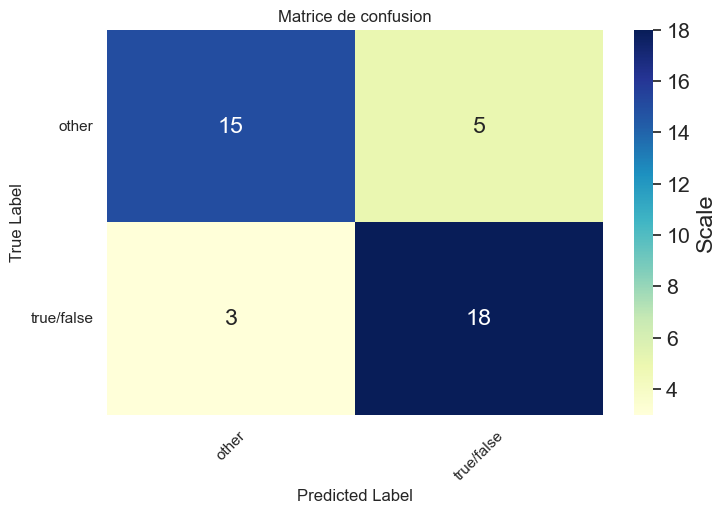

In [23]:
from sklearn.model_selection import train_test_split
import pickle
# Création d'un jeu d'apprentissage et de test
trainsize=0.9 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour
testsize= 0.1
seed=30

train_title,test_title,train_note,test_note=train_test_split(X_train_text_DE,Y_train_text_DE, train_size=trainsize,random_state=seed,test_size=testsize,stratify=Y_train_text_DE)

pipeline=Pipeline([
    ("cleaner", TextNormalizer(removedigit=False, getlemmatisation=True, getstemmer=True)),
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words=None)),
    ('svm', SVC(C=10, gamma=0.1, kernel='rbf',probability=True))
])
pipeline.fit(train_title,train_note)
filename='./Modele/True_And_False_VS_Other/TFO_svm_DE.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(pipeline, open(filename, "wb"))


print ("Chargement du modèle \n")
# le chargement se fait via la fonction load
clf_loaded = pickle.load(open(filename, 'rb'))
# affichage du modèle sauvegardé
print (clf_loaded)


# test  avec les données qu'il a apprise c'est parfait woahhha c'est beau
y_pred = clf_loaded.predict(test_title)
# autres mesures et matrice de confusion
MyshowAllScores(test_note,y_pred)

        2.2  RFC

In [26]:
print("Test RFC Text")
testRFC(X_train_text_DE,Y_train_text_DE,5,'/True_And_False_VS_Other/Texte/data_EN_And_DE_RFC_TFO_Texte')

Test RFC Text
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'rfc']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'rfc__n_estimators': [500, 1200], 'rfc__max_depth': [25, 30], 'rfc__min_samples_split': [5, 10, 15], 'rfc__min_samples_leaf': [1, 2]}
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
réalisé en  3698.907 s
Meilleur résultat : 0.710
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: True
	cleaner__getstemmer: True
	cleaner__removedigit: False
	rfc__max_depth: 25
	rfc__min_samples_leaf: 2
	rfc__min_samples_split: 5
	rfc__n_estimators: 500
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
      cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
121                       True                 True                 False   
657    

Sauvegarde du modèle dans  ./Modele/True_And_False_VS_Other/TFO_RFC_DE.pkl
Chargement du modèle 

Pipeline(steps=[('cleaner',
                 TextNormalizer(getlemmatisation=True, getstemmer=True)),
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('rfc',
                 RandomForestClassifier(max_depth=25, min_samples_leaf=2,
                                        min_samples_split=5,
                                        n_estimators=500))])
Accuracy : 0.780
Classification Report
              precision    recall  f1-score   support

       other    0.76190   0.80000   0.78049        20
  true/false    0.80000   0.76190   0.78049        21

    accuracy                        0.78049        41
   macro avg    0.78095   0.78095   0.78049        41
weighted avg    0.78142   0.78049   0.78049        41



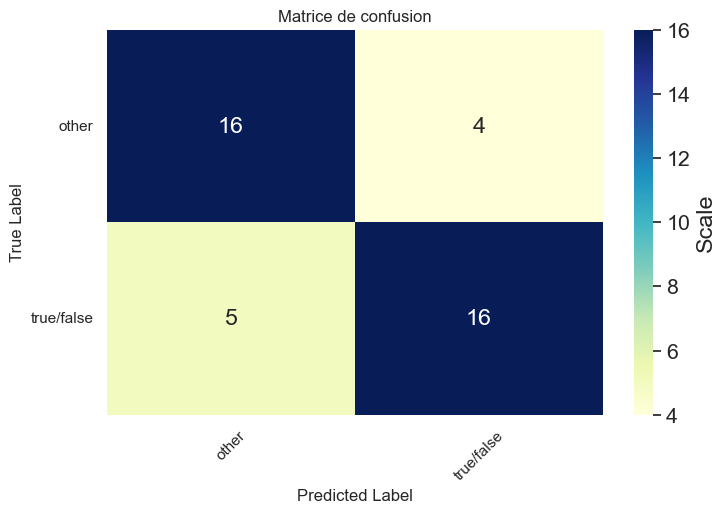

In [22]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# Création d'un jeu d'apprentissage et de test
trainsize=0.9 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour
testsize= 0.1
seed=30
train_title,test_title,train_note,test_note=train_test_split(X_train_text_DE,Y_train_text_DE, train_size=trainsize,random_state=seed,test_size=testsize,stratify=Y_train_text_DE)

pipeline=Pipeline([
    ("cleaner", TextNormalizer(removedigit=False, getlemmatisation=True, getstemmer=True)),
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words='english')),
    ('rfc', RandomForestClassifier(max_depth=25,min_samples_leaf=2, min_samples_split=5, n_estimators=500))
])
pipeline.fit(train_title,train_note)
filename='./Modele/True_And_False_VS_Other/TFO_RFC_DE.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(pipeline, open(filename, "wb"))



print ("Chargement du modèle \n")
# le chargement se fait via la fonction load
clf_loaded = pickle.load(open(filename, 'rb'))
# affichage du modèle sauvegardé
print (clf_loaded)


# test  avec les données qu'il a apprise c'est parfait woahhha c'est beau
y_pred = clf_loaded.predict(test_title)
# autres mesures et matrice de confusion
MyshowAllScores(test_note,y_pred)

        2.3  LR

In [27]:
print("Test LR text")
testLR(X_train_text_DE,Y_train_text_DE,5,'/True_And_False_VS_Other/Texte/data_EN_And_DE_LR_TFO_Texte')


Test LR text
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'lr']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 'lr__penalty': ['l2'], 'lr__C': [100, 10, 1.0, 0.1, 0.01]}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
réalisé en  1256.716 s
Meilleur résultat : 0.710
Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: False
	cleaner__getstemmer: True
	cleaner__removedigit: False
	lr__C: 100
	lr__penalty: 'l2'
	lr__solver: 'newton-cg'
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
      cleaner__getlemmatisation  cleaner__getstemmer  cleaner__removedigit  \
301                      False                 True                 False   
303                      False                 True                 False

        2.4  CART

In [28]:
print("Test CART, Texte")
testCART(X_train_text_DE,Y_train_text_DE,5,'/True_And_False_VS_Other/Texte/data_EN_And_DE_CART_TFO_Texte')


Test CART, Texte
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'CART']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'CART__max_depth': [10, 20, 30], 'CART__min_samples_split': [2, 5, 10], 'CART__min_samples_leaf': [1, 2, 4], 'CART__criterion': ['gini', 'entropy']}
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
réalisé en  4589.401 s
Meilleur résultat : 0.695
Ensemble des meilleurs paramètres :
	CART__criterion: 'gini'
	CART__max_depth: 20
	CART__min_samples_leaf: 1
	CART__min_samples_split: 5
	cleaner__getlemmatisation: True
	cleaner__getstemmer: False
	cleaner__removedigit: True
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
      CART__criterion  CART__max_depth  CART__min_samples_leaf  \
329             gini               20                       1   
1612   

        2.5  KNN

In [29]:
print("Test KNN text")
testKNeighborsClassifier(X_train_text_DE,Y_train_text_DE,5,'/True_And_False_VS_Other/Texte/data_EN_And_DE_KNN_TFO_Texte')


Test KNN text
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'KNN']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'KNN__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'KNN__weights': ['uniform', 'distance'], 'KNN__metric': ['minkowski', 'euclidean', 'manhattan']}
Fitting 5 folds for each of 10752 candidates, totalling 53760 fits
réalisé en  36830.463 s
Meilleur résultat : 0.712
Ensemble des meilleurs paramètres :
	KNN__algorithm: 'auto'
	KNN__metric: 'minkowski'
	KNN__n_neighbors: 4
	KNN__weights: 'distance'
	cleaner__getlemmatisation: True
	cleaner__getstemmer: True
	cleaner__removedigit: True
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
      KNN__algorithm KNN__metric  KNN__n_neighbors KNN__weights  \

        2.6  MB

In [30]:
print("MultinomialNB test Text")
testMNB(X_train_text_DE,Y_train_text_DE,5,'/True_And_False_VS_Other/Texte/data_EN_And_DE_MNB_TFO_Texte')

MultinomialNB test Text
Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'MultinomialNB']
parameters :
{'cleaner__getstemmer': [True, False], 'cleaner__removedigit': [True, False], 'cleaner__getlemmatisation': [True, False], 'tfidf__stop_words': ['english', None], 'tfidf__lowercase': [True, False], 'MultinomialNB__alpha': [0.1, 0.5, 1.0, 2.0], 'MultinomialNB__fit_prior': [True, False], 'MultinomialNB__force_alpha': [True, False]}
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
réalisé en  1360.580 s
Meilleur résultat : 0.693
Ensemble des meilleurs paramètres :
	MultinomialNB__alpha: 0.1
	MultinomialNB__fit_prior: True
	MultinomialNB__force_alpha: True
	cleaner__getlemmatisation: True
	cleaner__getstemmer: False
	cleaner__removedigit: True
	tfidf__lowercase: True
	tfidf__stop_words: None

Les premiers résultats : 
      MultinomialNB__alpha  MultinomialNB__fit_prior  \
105                   0.1                     False   
41                    0.1          